# Process volumetric fluorescent microscopy data with DataJoint Elements

This notebook will walk through processing volumetric two-photon calcium imaging data collected
from ScanImage and segmented with cellpose. While anyone can work through this
notebook to process volumetric fluorescent microscopy data through DataJoint's
`element-zstack` pipeline, for a detailed tutorial about the fundamentals of
DataJoint including table types, make functions, and querying, please see the
[DataJoint Tutorial](https://github.com/datajoint/datajoint-tutorials).

**Please note that uploading data to BossDB via this pipeline requires an API
token which can be obtained by creating an account at
[api.bossdb.io](https://api.bossdb.io). You will also need resource manager
permissions from the team at [BossDB](https://bossdb.org).**

The DataJoint Python API and Element ZStack offer a lot of features to
support collaboration, automation, reproducibility, and visualizations.
For more information on these topics, please visit our documentation: 
 
- [DataJoint Core](https://datajoint.com/docs/core/): General principles

- DataJoint [Python](https://datajoint.com/docs/core/datajoint-python/) and
  [MATLAB](https://datajoint.com/docs/core/datajoint-matlab/) APIs: in-depth reviews of
  specifics

- [DataJoint Element ZStack](https://datajoint.com/docs/elements/element-zstack/):
  A modular pipeline for volumetric calcium imaging data analysis


Let's start by importing the packages necessary to run this tutorial.

In [1]:
import os

# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

import datajoint as dj
import datetime
import numpy as np

### The Basics:

Any DataJoint workflow can be broken down into basic 3 parts:

- `Insert`
- `Populate` (or process)
- `Query`

In this demo we will:
- `Insert` metadata about an animal subject, recording session, and 
  parameters related to processing calcium imaging data through Suite2p.
- `Populate` tables with outputs of image processing including motion correction,
  segmentation, mask classification, fluorescence traces and deconvolved activity traces.
- `Query` the processed data from the database and plot calcium activity traces.

Each of these topics will be explained thoroughly in this notebook.

### Workflow diagram

This workflow is assembled from 5 DataJoint elements:
+ [element-lab](https://github.com/datajoint/element-lab)
+ [element-animal](https://github.com/datajoint/element-animal)
+ [element-session](https://github.com/datajoint/element-session)
+ [element-calcium-imaging](https://github.com/datajoint/element-calcium-imaging)
+ [element-zstack](https://github.com/datajoint/element-zstack)

Each element declares its own schema in the database. These schemas can be imported like
any other Python package. This workflow is composed of schemas from each of the Elements
above and correspond to a module within `workflow_zstack.pipeline`.

The schema diagram is a good reference for understanding the order of the tables
within the workflow, as well as the corresponding table type.
Let's activate the elements and view the schema diagram.

In [ ]:
from workflow_zstack.pipeline import (
    lab,
    subject,
    session,
    scan,
    volume,
    volume_matching,
    bossdb,
)

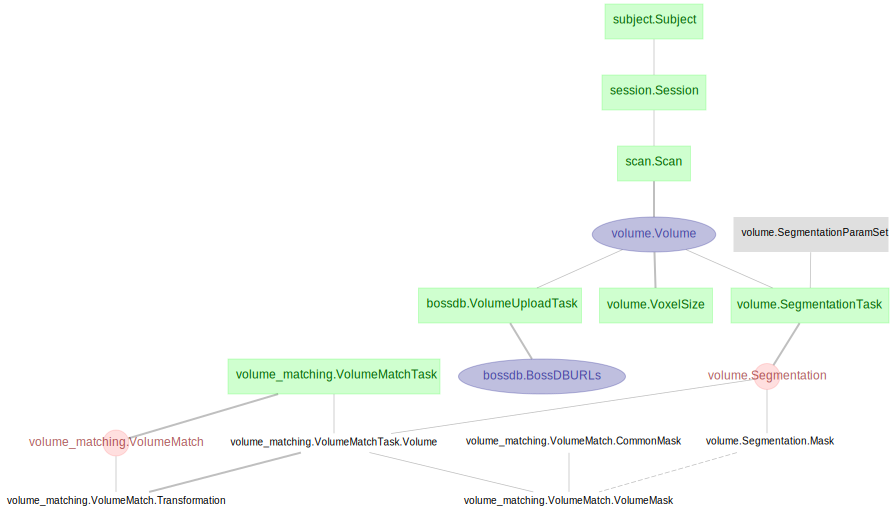

In [3]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(scan.Scan)
    + dj.Diagram(volume)
    + dj.Diagram(volume_matching)
    + dj.Diagram(bossdb)
)

### Diagram Breakdown

While the diagram above seems complex at first, it becomes more clear when it's
approached as a hierarchy of tables that **define the order** in which the
workflow **expects to receive data** in each of its tables. 

- Tables with a green, or rectangular shape expect to receive data manually using the
`insert()` function. 
- The tables higher up in the diagram such as `subject.Subject()`
should be the first to receive data. This ensures data integrity by preventing orphaned
data within DataJoint schemas. 
- Tables with a purple oval or red circle can be automatically filled with relevant data
  by calling `populate()`. For example `volume.Segmentation` and its part-table
  `volume.Segmentation.Mask` are both populated with `volume.Segmentation.populate()`.
- Tables connected by a solid line depend on attributes (entries) in the table
  above it.

#### Table Types

There are 5 table types in DataJoint. Each of these appear in the diagram above.

- **Manual table**: green box, manually inserted table, expect new entries daily, e.g. `Subject`, `Scan`.  
- **Lookup table**: gray box, pre inserted table, commonly used for general facts or parameters. e.g. `bossdb.UploadParamset`, `volume.SegmentationParamset`.  
- **Imported table**: blue oval, auto-processing table, the processing depends
  on the importing of external files. e.g. process of obtaining the `Volume` data requires
  raw data stored outside the database.  
- **Computed table**: red circle, auto-processing table, the processing does not
  depend on files external to the database, commonly used for computations such
  as `volume.Segmentation`, `volume_match.VolumeMatch`.   
- **Part table**: plain text, as an appendix to the master table, all the part
  entries of a given master entry represent a intact set of the master entry.
  e.g. Masks of `Segmentation`.

## Starting the workflow: Insert

### Insert entries into manual tables

To view details about a table's dependencies and attributes, use functions `.describe()`
and `.heading`, respectively.

Let's start with the first table in the schema diagram (the `subject` table) and view
the table attributes we need to insert. There are two ways you can do this: *run each
of the two cells below*

In [ ]:
subject.Subject.describe()

In [ ]:
subject.Subject.heading

In [ ]:
subject.Subject.insert1(
    dict(
        subject="subject1",
        sex="M",
        subject_birth_date="2023-01-01",
        subject_description="Cellpose segmentation of volumetric data.",
    ),
    skip_duplicates=True,
)
subject.Subject()

Let's repeat the steps above for the `Session` table and see how the output varies between `.describe` and `.heading`. 

In [ ]:
session.Session.describe()

In [ ]:
session.Session.heading

The cells above show the dependencies and attributes for the `session.Session` table.
Notice that `describe` shows the dependencies of the table on upstream tables. The
`Session` table depends on the upstream `Subject` table. 

Whereas `heading` lists all the attributes of the `Session` table, regardless of
whether they are declared in an upstream table. 

Here we will demonstrate a very useful way of inserting data by assigning the dictionary
to a variable `session_key`. This variable can be used to insert entries into tables that
contain the `Session` table as one of its attributes.

In [ ]:
session_key = dict(
    subject="subject1",
    session_id=0,
)
session.Session.insert1(
    dict(
        session_key,
        session_datetime=datetime.datetime.now(),
    ),
    skip_duplicates=True,
)
session.Session()

The `SessionDirectory` table locates the relevant data files in a directory path
relative to the root directory defined in your `dj.config["custom"]`. More
information about `dj.config` is provided at the end of this tutorial and is
particularly useful for local deployments of this workflow.

In [ ]:
session.SessionDirectory.describe()

In [ ]:
session.SessionDirectory.heading

In [ ]:
session.SessionDirectory.insert1(
    dict(session_key, session_dir="sub1"),
    skip_duplicates=True,
)
session.SessionDirectory()

Each volume requires an entry in the `Scan` table from
`element-calcium-imaging`. Here, we'll use `describe` and `heading` for the Scan
table and insert an entry for the current session.

In [ ]:
scan.Scan.describe()

In [ ]:
scan.Scan.heading

In [ ]:
scan.Scan.insert1(
    dict(
        session_key,
        scan_id=0,
        acq_software="ScanImage",
    ),
    skip_duplicates=True,
)
scan_key = (scan.Scan & "subject = 'subject1'").fetch1("KEY")

## Populate

### Automatically populate tables

`volume.Volume` is the first table in the pipeline that can be populated automatically.
If a table contains a part table, this part table is also populated during the
`populate()` call. `populate()` takes several arguments including the a session
key. This key restricts `populate()` to performing the operation on the session
of interest rather than all possible sessions which could be a time-intensive
process for databases with lots of entries.

Let's view the `volume.Volume` and populate it using the `populate()` call.

In [ ]:
volume.Volume.heading

In [ ]:
volume.Volume()

In [ ]:
volume.Volume.populate(scan_key, display_progress=True)

Let's view the information was entered into this table:

In [ ]:
volume.Volume()

We're almost ready to perform volume segmentation with `cellpose`. An important step before
processing is managing the parameters which will be used in that step. To do so, we will
insert parameters required by cellpose into a DataJoint table
`SegmentationParamSet`. This table keeps track of all combinations of your image
processing parameters. You can choose which parameters are used during
processing in a later step.

Let's view the attributes and insert data into `volume.SegmentationParamSet`.

In [ ]:
volume.SegmentationParamSet.heading

In [ ]:
volume.SegmentationParamSet.insert_new_params(
    segmentation_method="cellpose",
    paramset_idx=1,
    params=dict(
        diameter=8,
        min_size=2,
        do_3d=False,
        anisotropy=0.5,
        model_type="nuclei",
        channels=[[0, 0]],
        z_axis=0,
        skip_duplicates=True,
    ),
)

Now that we've inserted cellpose parameters into the `SegmentationParamSet` table,
we're almost ready to run image processing. DataJoint uses a `SegmentationTask` table to
manage which `Volume` and `SegmentationParamSet` should be used during processing. 

This table is important for defining several important aspects of
downstream processing. Let's view the attributes to get a better understanding. 

In [ ]:
volume.SegmentationTask.describe()

In [ ]:
volume.SegmentationTask.heading

The `SegmentationTask` table contains two important attributes: 
+ `paramset_idx`
+ `task_mode`

The `paramset_idx` attribute is tracks
your segmentation parameter sets. You can choose the parameter set on which
you want to run segmentation analysis based on this attribute. This
attribute tells the `Segmentation` table which set of parameters you are
processing in a given `populate()`.

The `task_mode` attribute can be set to either `load` or `trigger`. When set to `trigger`, the
segmentation step will run cellpose on the raw data.

In [ ]:
volume.SegmentationTask.insert1(
    dict(
        scan_key,
        paramset_idx=1,
        task_mode="trigger",
    ),
    skip_duplicates=True,
)

For now, Element ZStack only supports triggering cellpose. Now, we can popluate
the `Segmentation` table. This step may take several hours, depending on your
computer's capabilities.

In [ ]:
volume.Segmentation.populate(scan_key, display_progress=True)

Finally, we can upload our data to BossDB. The `bossdb` schema contains two
tables to the upload tasks, and execute the upload. The structure of these
tables mirrors the `volume` schema.

Volumetric data uploaded to BossDB requires information about voxel size. The
DataJoint table `volume.VoxelSize` can be used to insert this information for a
given dataset.

In [ ]:
volume.VoxelSize.heading

In [ ]:
volume.VoxelSize.insert1(dict(scan_key, width=0.001, height=0.001, depth=0.001))

Now, we can define the upload task by naming the collection, experiment,
and channel where the data should be uploaded. 

In [ ]:
bossdb.VolumeUploadTask.describe()

In [ ]:
bossdb.VolumeUploadTask.heading

In [ ]:
col_name = "dataJointTestUpload"
exp_name = "CaImagingFinal"
chn_name = "test1-seg"
bossdb.VolumeUploadTask.insert1(
    dict(
        scan_key,
        collection_name=col_name,
        experiment_name=exp_name,
        channel_name=chn_name,
        upload_type="annotation",
    )
)

In [ ]:
bossdb.VolumeUploadTask()

In [ ]:
upload_key = (bossdb.VolumeUploadTask & scan_key & "upload_type = 'image'").fetch("KEY")

In [ ]:
bossdb.BossDBURLs.populate(upload_key)

In [ ]:
bossdb.BossDBURLs()

To visualize the volumetric data, import the neuroglancer URL and paste it into
your browser.

In [ ]:
(bossdb.BossDBURLs & scan_key).fetch1("neuroglancer_url")

Explain how to get permission from APL to upload data. 

Create a schema to automatically generate neuroglancer link and insert into DJ
table. 

Include BossDBUpload in BossDBURLs as a computed/imported table. 